# Simulating the nucleosynthesis of elements in stars

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate

Construct a series of differential equations to simulate the nucleosynthesis of elements in stars due to the CNO1 cycle.

The differential equations are given by:

\begin{align}
\frac{d C12}{dt} &= H \left(N15 \right) \langle \sigma v \rangle_{N15 (p,\alpha)} - H \left(C12 \right) \langle \sigma v \rangle_{C12 (p,\gamma)} \\
\frac{d C13}{dt} &= H \left(C12 \right) \langle \sigma v \rangle_{C12 (p,\gamma)} - H \left(C13 \right) \langle \sigma v \rangle_{C13 (p,\gamma)} \\
\frac{d N14}{dt} &= H \left(C13 \right) \langle \sigma v \rangle_{C13 (p,\gamma)} - H \left(N14 \right) \langle \sigma v \rangle_{N14 (p,\gamma)} \\
\frac{d N15}{dt} &= H \left(N14 \right) \langle \sigma v \rangle_{N14 (p,\gamma)} - H \left(N15 \right) \langle \sigma v \rangle_{N15 (p,\alpha)} \\
\end{align}

Where:
- $H(X)$ is the relative abundance of element $X$.
- $\langle \sigma v \rangle_{X (p,\gamma/\alpha)}$ is the reaction rate of the reaction $X (p,\gamma/\alpha)$ determined by the following equation:

\begin{align}
\langle \sigma v \rangle_{X (p,\gamma/\alpha)} &= \int_0^{\infty} v \sigma(v) P(v) dv \\
&= \left( \frac{8}{\pi m_{01}}\right)^{1/2} \frac{1}{(kT)^{3/2}} \int_0^{\infty} E \sigma(E) e^{-E/kT} dE
\end{align}

Where:
- $m_{01}$ is the reduced mass of the system.
- $k$ is the Boltzmann constant.
- $T$ is the temperature of the star's core.
- $E$ is the energy
- $\sigma(E)$ is the cross section of the reaction.

Note: We ignore the reactions involving $O16$ and $N13$ because they decay very quickly relative to the other elements.

In [2]:
def reaction_rate(temp, mass, crossSection, kB = 8.617333262e-5):
    """
    Calculate the reaction rate (sigma v) for the respective reaction.
    
    Parameters
    ----------
    
    temp : float
        The temperature of the system in Kelvin
    mass : float
        The reduced mass of the system
    crossSection : float
        The cross section of the reaction
    kB : float
        The Boltzmann constant. Default is 8.617333262e-5 in eV/K
    
    Returns
    -------
    
    rate : float
        The reaction rate
    """
    constant = (8/(np.pi*mass))**(1/2) * 1/(kB * temp)**(3/2)
    
    integral = integrate.quad(
        lambda E: E * np.exp(-E/(kB * temp))*crossSection,
        0, np.inf)
    
    return constant * integral[0]

In [3]:
def calc_red_mass(m1, m2):
    """
    Calculate the reduced mass of a system
    
    Parameters
    ----------
    
    m1 : float
        The mass of the first particle
    m2 : float
        The mass of the second particle
    
    Returns
    -------
    
    red_mass : float
        The reduced mass of the system
    """
    return m1*m2/(m1+m2)

In [4]:
def CNO_cycle(elements, masses, temp=15e6, crossSection = 1, dT = 1):
    """
    Construct the differential equations for systems of the CNO1 cycle.
    
    Parameters
    ----------
    t : float
        Current time.
    elements : dict
        Dictionary containing the current values of the elements.
    temp : float
        The temperature of the system in Kelvin. Default is 15 million Kelvin.
    crossSection : float
        The cross section of the reaction. Default is 1 for the time being.
    masses : dict
        Masses of the elements in the system.
    dT : float
        Time step for the system. Default is 1.
        
    Returns
    -------
    dX : dict
        The differential equations for the system.
    """
    
    N15toC12 = (-(reaction_rate(temp, masses['N15'], crossSection) * elements['C12']/elements['H1']) + (reaction_rate(temp, masses['C12'], crossSection) * elements['N15']/elements['H1'])) if elements['N15'] > 0 else 0
    
    C12toC13 = (-(reaction_rate(temp, masses['C12'], crossSection) * elements['C12']/elements['H1']) + (reaction_rate(temp, masses['C13'], crossSection) * elements['C13']/elements['H1'])) if elements['C12'] > 0 else 0
    
    C13toN14 = (-(reaction_rate(temp, masses['C13'], crossSection) * elements['C13']/elements['H1']) + (reaction_rate(temp, masses['N14'], crossSection) * elements['N14']/elements['H1'])) if elements['C13'] > 0 else 0
    
    N14toN15 = (-(reaction_rate(temp, masses['N14'], crossSection) * elements['N14']/elements['H1']) + (reaction_rate(temp, masses['N15'], crossSection) * elements['N15']/elements['H1'])) if elements['N14'] > 0 else 0
    
    
    dX = {}
    dX['C12'] = N15toC12 - C12toC13
    dX['C13'] = C12toC13 - C13toN14
    dX['N14'] = C13toN14 - N14toN15
    dX['N15'] = N14toN15 - N15toC12
    dX['H1'] = 0
    
    return dX

In [5]:
def integrate_system(elements, masses, temp=15e6, crossSection = 1):
    """
    Integrate the system of differential equations.
    
    Parameters
    ----------
    elements : dict
        Dictionary containing the initial values of the elements.
    temp : float
        The temperature of the system in Kelvin. Default is 15 million Kelvin for the core of the Sun.
    crossSection : float
        The cross section of the reaction. Default is 1 for the time being.
    masses : dict
        Masses of the elements in the system.
        
    Returns
    -------
    t : ndarray
        Array containing the time steps.
    X : ndarray
        Array containing the values of the elements.
    """
    
    t = np.linspace(0, 1e3, 1000)
    dT = t[1] - t[0]
    X = []
    X.append(elements)
    
    for i in range(1, len(t)):
        dX = CNO_cycle(elements, masses, temp, crossSection, dT)
        
        X.append({key: X[i-1][key] + dT*dX[key] for key in dX})
        elements = X[i]
            
    
    return t, X

In [6]:
masses = {
    'H1': 1.007825,
    'C12': 12.000000,
    'C13': 13.003355,
    'N14': 14.003074,
    'N15': 15.000109,
    'alpha': 4.002603,
    'proton': 1.007276
} # in atomic mass units

elements = {
    'H1': 10000,
    'C12': 1000,
    'C13': 0,
    'N14': 0,
    'N15': 0
}


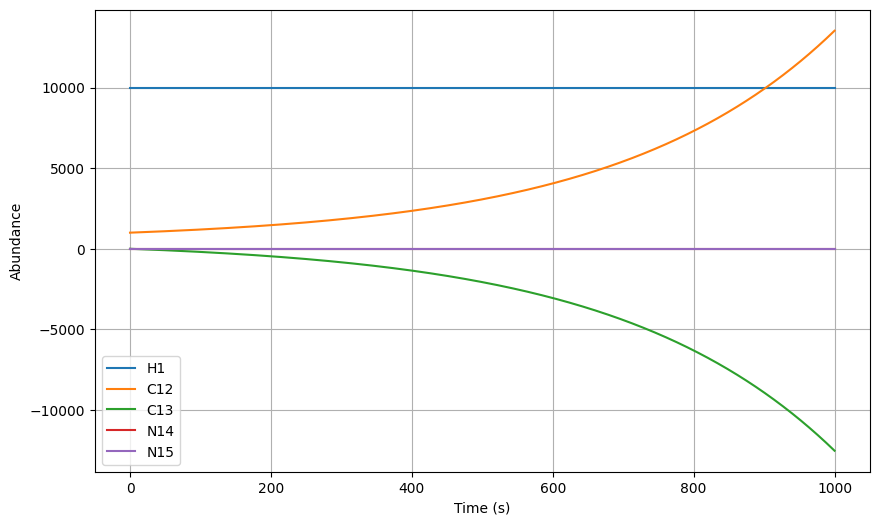

In [7]:
# plot the results
t, X = integrate_system(elements, masses)

plt.figure(figsize=(10, 6))
plt.plot(t, [x['H1'] for x in X], label='H1')
plt.plot(t, [x['C12'] for x in X], label='C12')
plt.plot(t, [x['C13'] for x in X], label='C13')
plt.plot(t, [x['N14'] for x in X], label='N14')
plt.plot(t, [x['N15'] for x in X], label='N15')
plt.xlabel('Time (s)')
plt.ylabel('Abundance')
plt.legend()
plt.grid()
plt.show()
